# Data Importing

In [ ]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2


**Changable_Parameter**

In [ ]:
#here image size is 256x256
IMAGE_SIZE = 150
#every time process 32 images (61x31)~1951
BATCH_SIZE = 32
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 80
NUM_CLASSES = 2
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=20
data_dir ="E:\\teaLEafWork\\Tea leaf 🌿-20240418T082847Z-001\\Tea leaf 🌿"

model_name="DenseNet121"

In [ ]:
import tensorflow as tf


# Define image parameters
img_height = IMAGE_SIZE
img_width = img_height
batch_size = BATCH_SIZE

# Define data augmentation parameters
# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of the data will be used for validation
    rotation_range=60,  # Rotate images randomly up to 60 degrees (increased from 20)
    zoom_range=0.2,  # Zoom range [1-zoom_range, 1+zoom_range]
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # Flip images vertically (added)
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)


train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)


Found 676 images belonging to 2 classes.


Found 168 images belonging to 2 classes.


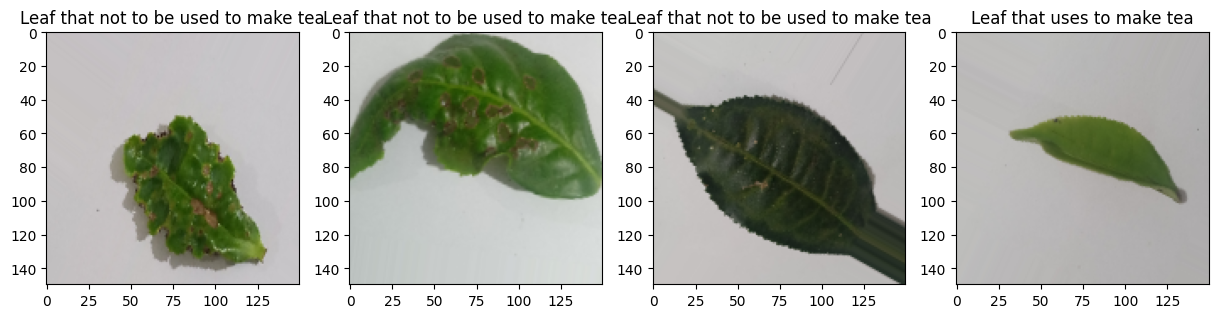

In [ ]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, BATCH_SIZE)

    # Plot the image
    axes[i].imshow(images[random_index])

    # Get the corresponding label
    label = labels[random_index]

    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0,ResNet50,InceptionV3,NASNetMobile,EfficientNetV2L,DenseNet121

model= DenseNet121(weights = 'imagenet',
                 include_top = False,
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                 )

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 BatchNormalization False
8 Activation False
9 Conv2D False
10 BatchNormalization False
11 Activation False
12 Conv2D False
13 Concatenate False
14 BatchNormalization False
15 Activation False
16 Conv2D False
17 BatchNormalization False
18 Activation False
19 Conv2D False
20 Concatenate False
21 BatchNormalization False
22 Activation False
23 Conv2D False
24 BatchNormalization False
25 Activation False
26 Conv2D False
27 Concatenate False
28 BatchNormalization False
29 Activation False
30 Conv2D False
31 BatchNormalization False
32 Activation False
33 Conv2D False
34 Concatenate False
35 BatchNormalization False
36 Activation False
37 Conv2D False
38 BatchNormalization False
39 Activation False
40 Conv2D False
41 Concatenate False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 BatchNormalization False
46 Activation False
4

**Fine Tuning**

In [ ]:
# # for layer in model.layers[:260]:
# #    layer.trainable = False
# # for layer in model.layers[260:]:
# #    layer.trainable = True

# # print('Last block of the conv_base is now trainable')


# for i, layer in enumerate(model.layers):
#    print(i, layer.name, layer.trainable)

In [ ]:

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed on top of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    #top_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    #top_model = Dropout(0.5)(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [ ]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 156, 156, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1/conv[0][0]']    

 rmalization)                                                                                     
                                                                                                  
 conv2_block3_0_relu (Activ  (None, 38, 38, 128)          0         ['conv2_block3_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 38, 38, 128)          16384     ['conv2_block3_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 38, 38, 128)          512       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

# Training

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 10:
         return lr
     else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model")
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

**CheckPoints**

In [ ]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [ ]:


model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,lr_scheduler,check,csv_logger],
                    initial_epoch=0)

Epoch 1/80
22/22 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.7825
Epoch 1: val_loss improved from inf to 0.18625, saving model to Model\DenseNet121_Model.hdf5


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 69s 3s/step - loss: 0.7393 - accuracy: 0.7825 - val_loss: 0.1863 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 2/80
22/22 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9142
Epoch 2: val_loss improved from 0.18625 to 0.12366, saving model to Model\DenseNet121_Model.hdf5
22/22 [==============================] - 61s 3s/step - loss: 0.2342 - accuracy: 0.9142 - val_loss: 0.1237 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 3/80
22/22 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9453
Epoch 3: val_loss improved from 0.12366 to 0.06201, saving model to Model\DenseNet121_Model.hdf5
22/22 [==============================] - 60s 3s/step - loss: 0.1346 - accuracy: 0.9453 - val_loss: 0.0620 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 4/80
22/22 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9571
Epoch 4: val_loss did not improve from 0.06201
22/22 [==============================] - 59s 3s/ste

# Result

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

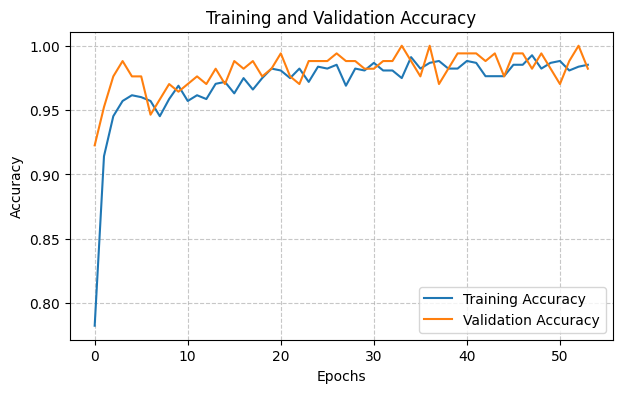

In [ ]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

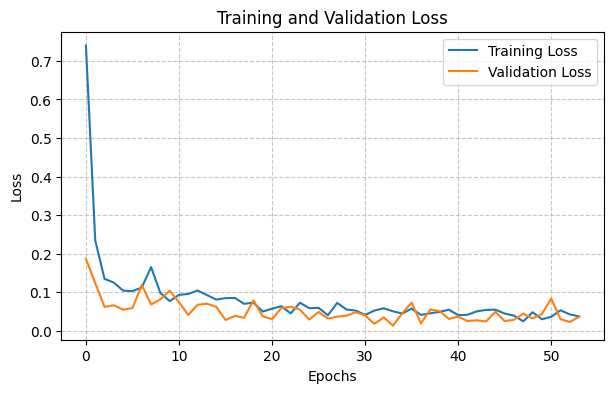

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
score = model.evaluate(validation_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

6/6 [==============================] - 12s 2s/step - loss: 0.0526 - accuracy: 0.9821
Test Loss: 0.05263465270400047
Test accuracy: 98.21428656578064


In [ ]:
import numpy as np
from sklearn.metrics import classification_report


pred = model.predict(validation_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(pred, axis=1)

# Get the true labels from the validation generator
true_labels = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Compute the classification report with zero_division parameter set to 'warn'
report = classification_report(true_labels, predicted_labels, target_names=class_labels, zero_division=1)

print("Classification Report:")
print(report)


6/6 [==============================] - 14s 2s/step
Classification Report:
                                      precision    recall  f1-score   support

Leaf that not to be used to make tea       0.58      0.58      0.58        98
          Leaf that uses to make tea       0.41      0.40      0.40        70

                            accuracy                           0.51       168
                           macro avg       0.49      0.49      0.49       168
                        weighted avg       0.50      0.51      0.51       168



<Figure size 1200x1200 with 0 Axes>

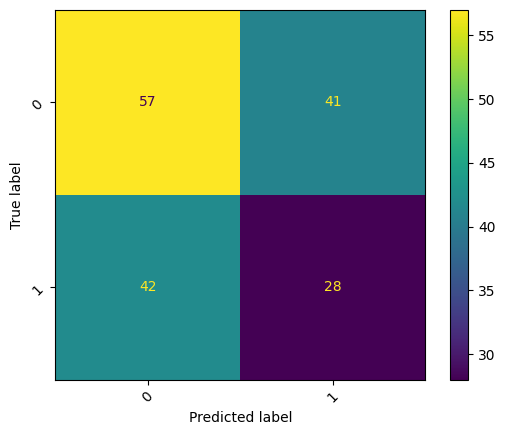

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix with adjusted figure size
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
disp.plot()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=45)  # Rotate y-axis labels for better readability
plt.show()


In [ ]:
target_names = []
y_pred = model.predict(validation_generator).argmax(axis=1)
for key in validation_generator.class_indices:
    target_names.append(key)

print(target_names)

from sklearn.metrics import classification_report

#Compute the classification report with zero_division parameter set to 'warn'
report = classification_report(validation_generator.classes, y_pred, target_names=target_names)

# print('Classification Report:')
print(report)


6/6 [==============================] - 12s 2s/step
['Leaf that not to be used to make tea', 'Leaf that uses to make tea']
                                      precision    recall  f1-score   support

Leaf that not to be used to make tea       0.57      0.57      0.57        98
          Leaf that uses to make tea       0.40      0.40      0.40        70

                            accuracy                           0.50       168
                           macro avg       0.49      0.49      0.49       168
                        weighted avg       0.50      0.50      0.50       168

